# MMI 701: Multimedia Signal Processing
## Frequency-domain analysis of signals

- In addition to what we used during the past two weeks we will use the ```sympy``` library for dealing with the continuous-time signals

In [86]:
import numpy as np
import scipy.signal as sgn
import sympy as sp
import matplotlib.pyplot as plt

### Continuous-time Fourier Series

- We will first define t as a symbolic variable and then calculate the Fourier series coefficients by directly integrating a periodic signal
- The periodic signal comprises a sum of two simusoidal signals having $F_0=100$ Hz and $F_1=2F_0=200$ Hz frequencies
- ```sympy```is slow but it allows symbolic calculation of the results which is good!

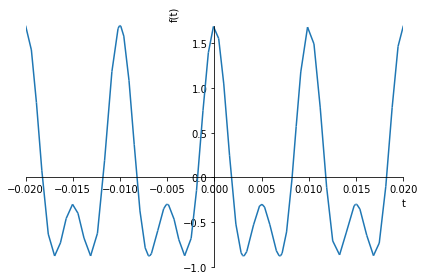

In [87]:
t = sp.symbols('t') # Define t as a symbol
F0 = 100. # We could have defined F0 as a symbol as well. However, let's keep it fixed
T0 = 1/F0 # Calculate the fundamental period
sigcos1f = sp.cos(2 * np.pi * F0 * t) # Calculate the first part of the signal
sigcos2f = sp.cos(2 * np.pi * 2 * F0 * t) # Calculate the second part of the signal
sigcos = sigcos1f + 0.7 * sigcos2f # Calculate the signal that we will work with
sp.plot(sigcos, (t, -0.02, 0.02)) # Plot four periods of the the signal

- We will now define a list which we will append values that we calculate
- We pick a completely random $t_0$ in order to show that the signal being periodic means this selection has no effect on the Fourier series coefficients
- You will notice that ```sympy``` is very slow. You may have to wait a little. In most cases, ```sympy```will be largely irrelevant since you would be dealing with discrete-time signals. However, it is worth knowing about it since, it is helpful in contexts where you may be after an analytical (as opposed to numerical) solution.

In [88]:
ckarr = []
t0 = 0.7156767 # We picked a random instant. Since the signal is periodic, this should have no effect on the results
for k in range(-3,4):
    ck = (1/T0) * sp.integrate(sigcos * sp.exp(-1j * 2 * np.pi * F0 * k * t), (t, t0, t0+T0)) # We calculate a symbolic expression for the Fourier series coefficients
    f = sp.lambdify(t, ck.evalf()) # Convert the result to a lambda function
    ckarr.append(f(0)) # Evaluate for any time instant. The specific choice does not matter

<StemContainer object of 3 artists>

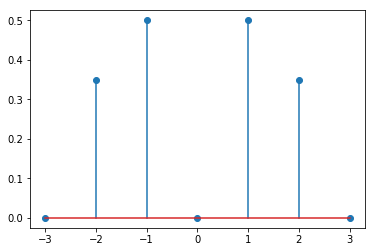

In [89]:
plt.stem(np.arange(-3,4), np.real(ckarr)) # The result is complex but with very small imaginary parts. In order to plot, use the real part!

#### Parseval's (Plancherel's) relation for Continuous-time Fourier Series

- We have shown that the average power of the signal is equal to the sum of squares of the Fourier series coefficients. Let us whos that this is indeed the case

In [90]:
Psig_sym = 1/T0 * sp.integrate(sigcos**2, (t, t0, t0+T0))
Psig = sp.lambdify(t, Psig_sym.evalf())
Pck = np.sum(np.abs(ckarr)**2)
print("Pck: ", Pck)
print("Psig:", Psig(0))

('Pck: ', 0.7449999999999855)
('Psig:', 0.745000000000007)


### Continuous-time Fourier Transform

- We will now use a signal with a finite time-support and calculate its continuous-time Fourier transform.
- We will use a piecewise function in ```sympy```

In [121]:
pulse = sp.Piecewise((1, abs(t)<T0/2), (0, True))

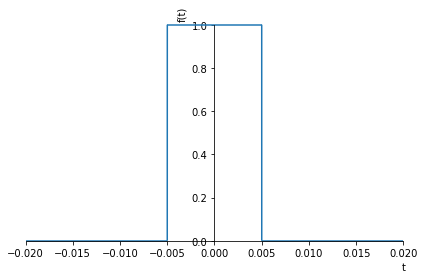

In [122]:
sp.plot(pulse, (t, -0.02, 0.02))

- We will set the integration limits to be wider than $\pm{}T_0/2$ to show that ```sympy``` is capable of piecewise linear functions

In [93]:
F = sp.symbols('F')
X_F = sp.integrate(pulse * sp.exp(-sp.I * 2 * sp.pi * F * t), (t, -T0, T0))

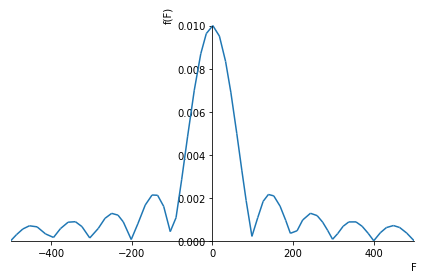

In [95]:
sp.plot(abs(X_F), (F, -500, 500)) # Plot the magnitude spectrum

### Discrete-time Fourier Series

- We will not need to use symbolic math anymore since we can now simply define our signals sample-by-sample
- We will first define a periodic signal with a period $N=20$, and then calculate its Fourier series expansion.
- We will define the periodic function as a *recursive function* that takes the sample index and the fundamental period. The output will be sample-by-sample, which is not very practical but will serve our purpose.

In [96]:
def sawtooth(n, N):
    if (0 <= n) & (n < N):
        sig = np.float(n) # Always remember to typecast. Python (Unlike MATLAB) does not infer from the context that you are using floats
    else:
        sig = sawtooth(np.mod(n,N), N)
    return sig

- Let us first see that this function will generate a sawtooth signal
- Observe in the stem plot that the signal is periodic with period $N=20$

In [97]:
sig = []
for n in range(-50, 51):
    sig.append(sawtooth(n, 20))
sigsw = np.array(sig)

<StemContainer object of 3 artists>

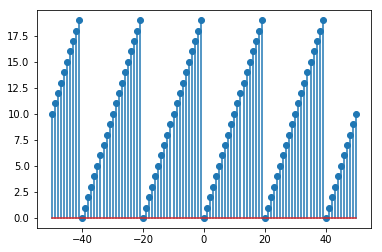

In [98]:
plt.stem(np.arange(-50,51), sigsw)

- Let us now define a function for calculating the discrete-time Fourier series expansion of our periodic signal
- Remember: In Python functions are also objects which can be passed around (without even a function handle as in MATLAB or a pointer as in C++). This sometimes makes things much easier as you will see in the following function. This is just to show you that this is possible. 
- **Normally we would have been passing a ```numpy``` array and not a function!**

In [99]:
def dtfs(sigfun, N):
    
    ckarr = np.zeros(N, dtype=complex) # You need to specify the type of the array. Otherwise, numpy will complain!
    
    for k in range(N):
        for n in range(N):
            ckarr[k] += sigfun(n, N) * np.exp(-1j * 2 * np.pi * k * n / N) # This is a += b is shorthand for a = a + b
            
    return ckarr / N

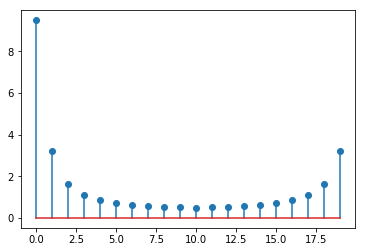

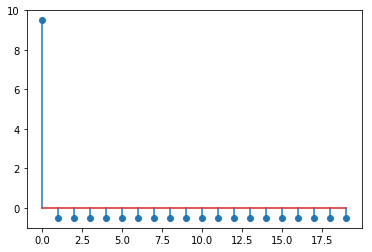

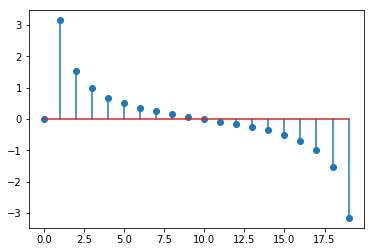

In [100]:
ckarr = dtfs(sawtooth, 20)
plt.stem(np.arange(0,20),np.abs(ckarr))
plt.show()
plt.stem(np.arange(0,20),np.real(ckarr))
plt.show()
plt.stem(np.arange(0,20),np.imag(ckarr))
plt.show()

- Does Parseval relation also work, then?

<StemContainer object of 3 artists>

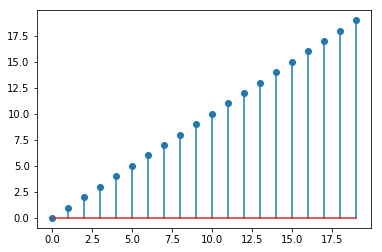

In [101]:
sigsw_singleperiod = sigsw[50:70]
plt.stem(sigsw_singleperiod)

In [102]:
Psig = np.sum(sigsw_singleperiod**2)/20
Pck = np.sum(np.abs(ckarr)**2)

In [103]:
print("Signal power:", Psig)
print("Squared sum of Fourier series coefficients:", Pck)

('Signal power:', 123.5)
('Squared sum of Fourier series coefficients:', 123.49999999999993)


- Pretty close, but numerical precision makes it not exacly equal. If we wanted to check this condition (for example in a unit test), we could use ```np.testing.assert_almost_equal``` [https://numpy.org/doc/stable/reference/generated/numpy.testing.assert_almost_equal.html](https://numpy.org/doc/stable/reference/generated/numpy.testing.assert_almost_equal.html)
- Did I mention that Python, numpy, scipy, sympy have excellent documentation? Please do check!

In [104]:
np.testing.assert_almost_equal(Psig, Pck, decimal=10) # This will not break the flow.
print("Yes! They are equal up to 10 decimal points!")

Yes! They are equal up to 10 decimal points!


In [105]:
np.testing.assert_almost_equal(Psig, Pck, decimal=100) # This will raise an assertion error and break the program flow as you will see below
print("I am a happy IPython notebook!")

AssertionError: 
Arrays are not almost equal to 100 decimals
 ACTUAL: 123.5
 DESIRED: 123.49999999999993

- Let us now resynthesise the signal by defining the ```idtft``` function
- This time we will pass the numpy array containing the DTFS coefficients
- Since we know that the signal is periodic, we can resynthesise any number of samples of the signal

In [106]:
def idtfs(ck, Nmax):
    N = len(ck)
    sigrec = np.zeros(Nmax, dtype=complex) # We know that the complex part will be very small but we also don't want numpy to complain!
    for n in range(Nmax):
        for k in range(N):
            sigrec[n] += ck[k] * np.exp(1j * 2 * np.pi * k * n / N)
    return np.real(sigrec)

<StemContainer object of 3 artists>

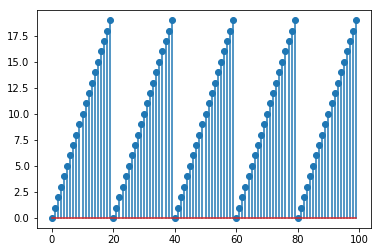

In [107]:
swt_rec = idtfs(ckarr, 100)
plt.stem(np.arange(0,100), swt_rec) # Since we calculated the signal for n=0...99 this figure is different than the earlier

### Discrete-time Fourier Transform

- We can use a numerical implementation for the DTFT, but we will again have to use symbolic math for IDTFT
- We will use the discrete-time signal that we discussed in the lecture video. For that we will first define the ```rect```signal. We will then use two rect signals to construct our signal. We will use that signal to calculate the DTFT of the signal. 

In [108]:
def delay(sigfun, n, offset, *args): # sigfun is a function to generate a discrete-time signal, *args are remaining arguments to be passed on to the function
    d = n - offset
    return sigfun(d, *args)

def step(n):
    if n >=0:
        return 1
    return 0

def rect(n, N):
    s1 = delay(step, n, 0)
    s2 = delay(step, n, N)
    return s1-s2

- We will now define a ```lambda``` function for our signal. This is something I rarely use myself despite being a very useful way to code less important and shorted functions.
- What is a lambda function?: https://realpython.com/python-lambda/

In [109]:
sig = lambda n, N1, N2, A1, A2, offset1, offset2 :  A1 * delay(rect, n, offset1, N1) + A2 * delay(rect, n, offset2, N2)

In [110]:
sg = []
for n in range(-10,10):
    sg.append(sig(n, 4, 3, 1, 0.5, 0, 4))
sg = np.array(sg)

<StemContainer object of 3 artists>

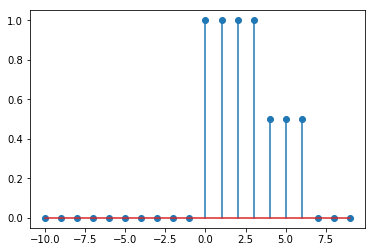

In [111]:
plt.stem(np.arange(-10,10), sg)

- DTFT is an infinite series, but our DT signal has finite time support. This means that we only need to use the samples for which the signal is non-zero
- We will again have to use ```sympy```since the frequency variable $\omega$ is a continuous variable

In [112]:
omega = sp.symbols('omega')
def dtft(sigfun, nmin, nmax, *args):
    X = 0
    for n in range(nmin, nmax + 1):
        X += sigfun(n, *args) * sp.exp(-sp.I * omega * n)
    return X

In [113]:
X = dtft(sig, 0, 7, 4, 3, 1, 0.5, 0, 4) # nmin =0, nmax = 7, all the rest of the inputs are arguments to be passed on to sig

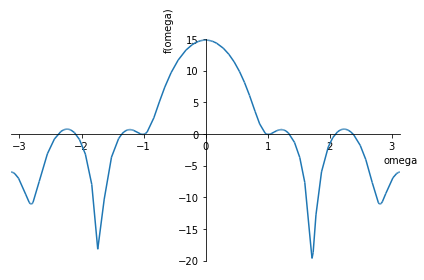

In [114]:
sp.plot(20*sp.log(abs(X),10), (omega, -sp.pi, sp.pi)) # Plot the magnitude spectrum (in dB)

### Gibbs' Phenomenon

- We will now show the effects of the truncation length on DTFT.

In [115]:
def idtft(X, omega):
    xn = sp.integrate(X, (omega, -sp.pi, sp.pi))
    return xn

In [116]:
X = sp.Piecewise((1, (abs(omega)<sp.pi/2)), (0, True))

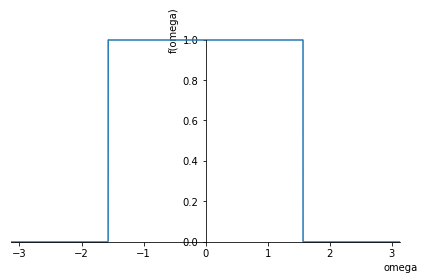

In [117]:
sp.plot(X, (omega, -sp.pi, sp.pi))

In [118]:
ns = sp.symbols('ns')

def idtft(X):
    xn = (1/(2*np.pi))*sp.integrate(X * sp.exp(sp.I * omega * ns), (omega, -sp.pi, sp.pi))
    fn = sp.lambdify(ns, xn)
    return fn

In [119]:
fn = idtft(X)

<string>:2: RuntimeWarning: divide by zero encountered in cdouble_scalars
<string>:2: RuntimeWarning: invalid value encountered in cdouble_scalars


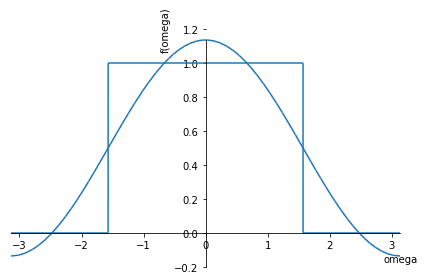

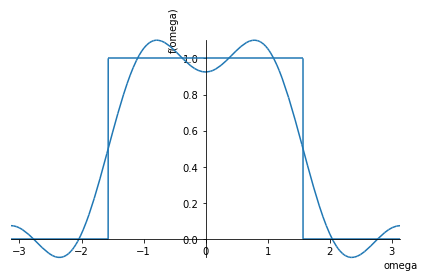

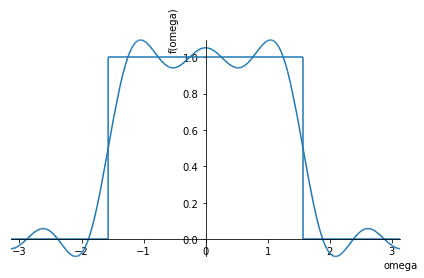

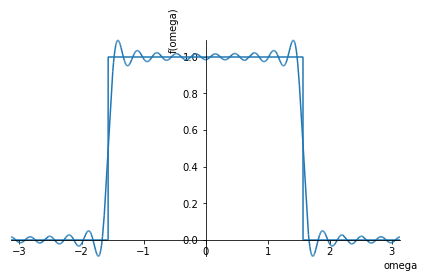

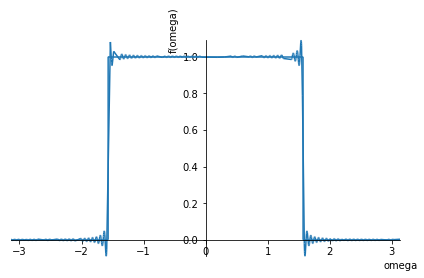

In [120]:
Xg = dtft(fn, -1, 1)
p1 = sp.plot(Xg, X, (omega, -sp.pi, sp.pi))
Xg = dtft(fn, -3, 3)
p2 = sp.plot(Xg, X, (omega, -sp.pi, sp.pi))
Xg = dtft(fn, -5, 5)
p3 = sp.plot(Xg, X, (omega, -sp.pi, sp.pi))
Xg = dtft(fn, -20, 20)
p3 = sp.plot(Xg, X, (omega, -sp.pi, sp.pi))
Xg = dtft(fn, -100, 100)
p3 = sp.plot(Xg, X, (omega, -sp.pi, sp.pi))

- DTFT tries its best to approximate the edges of the signal but the overshoot remains.

#### © 2020, Huseyin Hacihabiboglu, (hhuseyin@metu.edu.tr), METU Graduate School of Informatics